# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw
from numpy import asarray
from bs4 import BeautifulSoup as bs

from object_detection.utils import config_util, visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Funções Úteis

In [2]:
porcentagem_acerto = 0.1

In [3]:
def existeRBC(arquivo):
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")
        lista_objetos = bs_content.find_all("object")

        for objeto in lista_objetos:
            nome = objeto.find("name")
            if "RBC" in nome:
                return True

    return False

In [4]:
def criarArquivo(mensagem, path):
    path = path.replace("imagens", "info")
    path = path.replace(".jpg", ".txt")
    mensagem = mensagem.replace("RBCs", "")
    arquivo = open(path, "w")
    arquivo.write("RBC\n")
    arquivo.write(mensagem)
    arquivo.close()

In [5]:
# Converte a imagem em array
def convertImageToArray(path):
    image = Image.open(path)
    array = asarray(image)
    return array


# Imprime as detecções na imagem
def plotDetections(imagem, boxes, classes, scores, categoria, nome=None):
    imagemDeteccao = imagem.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        imagemDeteccao, boxes, classes, scores, categoria, use_normalized_coordinates=True, min_score_thresh=porcentagem_acerto)

    if nome:
        pontuacao = np.squeeze(scores)
        contador = 0
        for i in range(100):
            if scores is None or pontuacao[i] > porcentagem_acerto:
                contador = contador + 1

        mensagem = str(contador) + " RBCs"

        plt.imsave(nome, imagemDeteccao)
        img = Image.open(nome)
        editor = ImageDraw.Draw(img)
        editor.text((10, 10), mensagem, fill=(255, 255, 0))

        criarArquivo(mensagem, nome)

        img.save(nome)
    else:
        plt.imshow(imagemDeteccao)


# Análise das Imagens

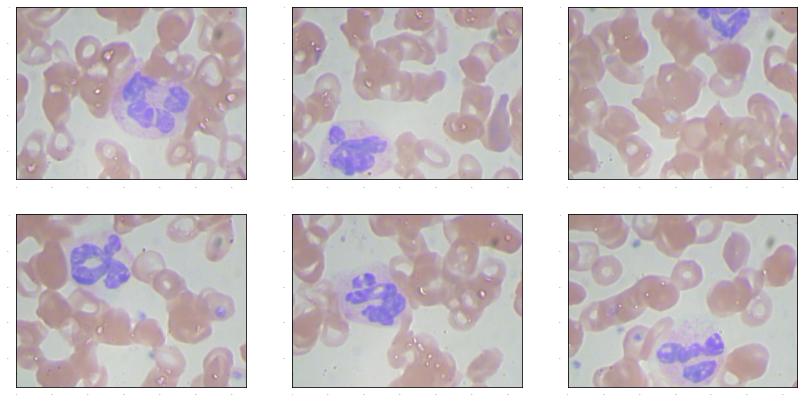

In [6]:
train_images_dir = './dataset-triple/train/imagens/'
train_images = []

# Coleta as imagens, converte em array e salva em array geral
for elemento in os.listdir(train_images_dir):
    imagem = os.path.join(train_images_dir, elemento)
    info = imagem.replace("imagens", "coordenadas")
    info = info.replace("jpg", "xml")
    if existeRBC(info):
        train_images.append(convertImageToArray(imagem))

# Parâmetros para a plotagem
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# Plotagem da visualização teste
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plt.imshow(train_images[indice])
plt.show()

# Leitura das Coordenadas

In [7]:
# Função para realizar a conversão das coordenadas do XML para o formato utilizado no plot
def calcularPosicao(lista):
    xmin = lista[0]
    ymin = lista[1]
    xmax = lista[2]
    ymax = lista[3]

    larguraImagem = 640
    alturaImagem = 480

    xmin = xmin / larguraImagem
    ymin = ymin / alturaImagem
    xmax = xmax / larguraImagem
    ymax = ymax / alturaImagem

    return [ymin, xmin, ymax, xmax]

In [8]:
# Função para coletar as coordenadas do arquivo XML
def encontraRBC(arquivo):
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")

        lista_objetos = bs_content.find_all("object")
        for objeto in lista_objetos:
            nome = objeto.find("name")
            xmin = objeto.find("xmin")
            ymin = objeto.find("ymin")
            xmax = objeto.find("xmax")
            ymax = objeto.find("ymax")

            if "RBC" in nome:
                nome = str(nome)
                xmin = str(xmin)
                ymin = str(ymin)
                xmax = str(xmax)
                ymax = str(ymax)

                # newNome = nome[nome.find(">")+1:nome.find("</name>")]
                newXmin = int(xmin[xmin.find(">")+1:xmin.find("</xmin>")])
                newYmin = int(ymin[ymin.find(">")+1:ymin.find("</ymin>")])
                newXmax = int(xmax[xmax.find(">")+1:xmax.find("</xmax>")])
                newYmax = int(ymax[ymax.find(">")+1:ymax.find("</ymax>")])

                return [newXmin, newYmin, newXmax, newYmax]
                   
    return False

print(encontraRBC("dataset-triple/train/coordenadas/BloodImage_00125.xml"))

[333, 174, 421, 274]


In [9]:
# Importação das coordenadas para um array
coordenadas_dir = 'dataset-triple/train/coordenadas/'
coordenadas_info = []

for arquivo in os.listdir(coordenadas_dir):
    if existeRBC(coordenadas_dir + arquivo):
        coordenadas_info.append(np.array(
            [calcularPosicao(encontraRBC(coordenadas_dir + arquivo))], dtype=np.float32))

for i in range(0, 6):
    print(coordenadas_info[i])

[[0.7      0.121875 0.90625  0.2875  ]]
[[0.75208336 0.540625   0.9458333  0.696875  ]]
[[0.20416667 0.6015625  0.4125     0.8171875 ]]
[[0.19375   0.4953125 0.40625   0.6625   ]]
[[0.50416666 0.675      0.6770833  0.825     ]]
[[0.23958333 0.4265625  0.4625     0.603125  ]]


# Preparando dados para treinamento

In [10]:
# Definição da classe
rbc_id = 1
num_classes = 1
categorias = {rbc_id: {'id': rbc_id, 'name': 'rbc'}}

train_images_tensors = []
coordenadas_info_tensors = []
offset = 1
classes_tensors = []

# Função Zip = Tupla entre dois arryas (Imagens + Coordenadas)
for (train_image, coordenada) in zip(train_images, coordenadas_info):
    train_images_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image, dtype=tf.float32), axis=0))
    coordenadas_info_tensors.append(tf.convert_to_tensor(coordenada, dtype=tf.float32))
    indices = tf.convert_to_tensor(np.ones(shape=[coordenada.shape[0]], dtype=np.int32) - offset)
    classes_tensors.append(tf.one_hot(indices, num_classes))
    
print('Dados preparados')

Dados preparados


# Visualizando imagens com coordenadas

In [11]:
print(len(train_images))
print(len(coordenadas_info))

278
278


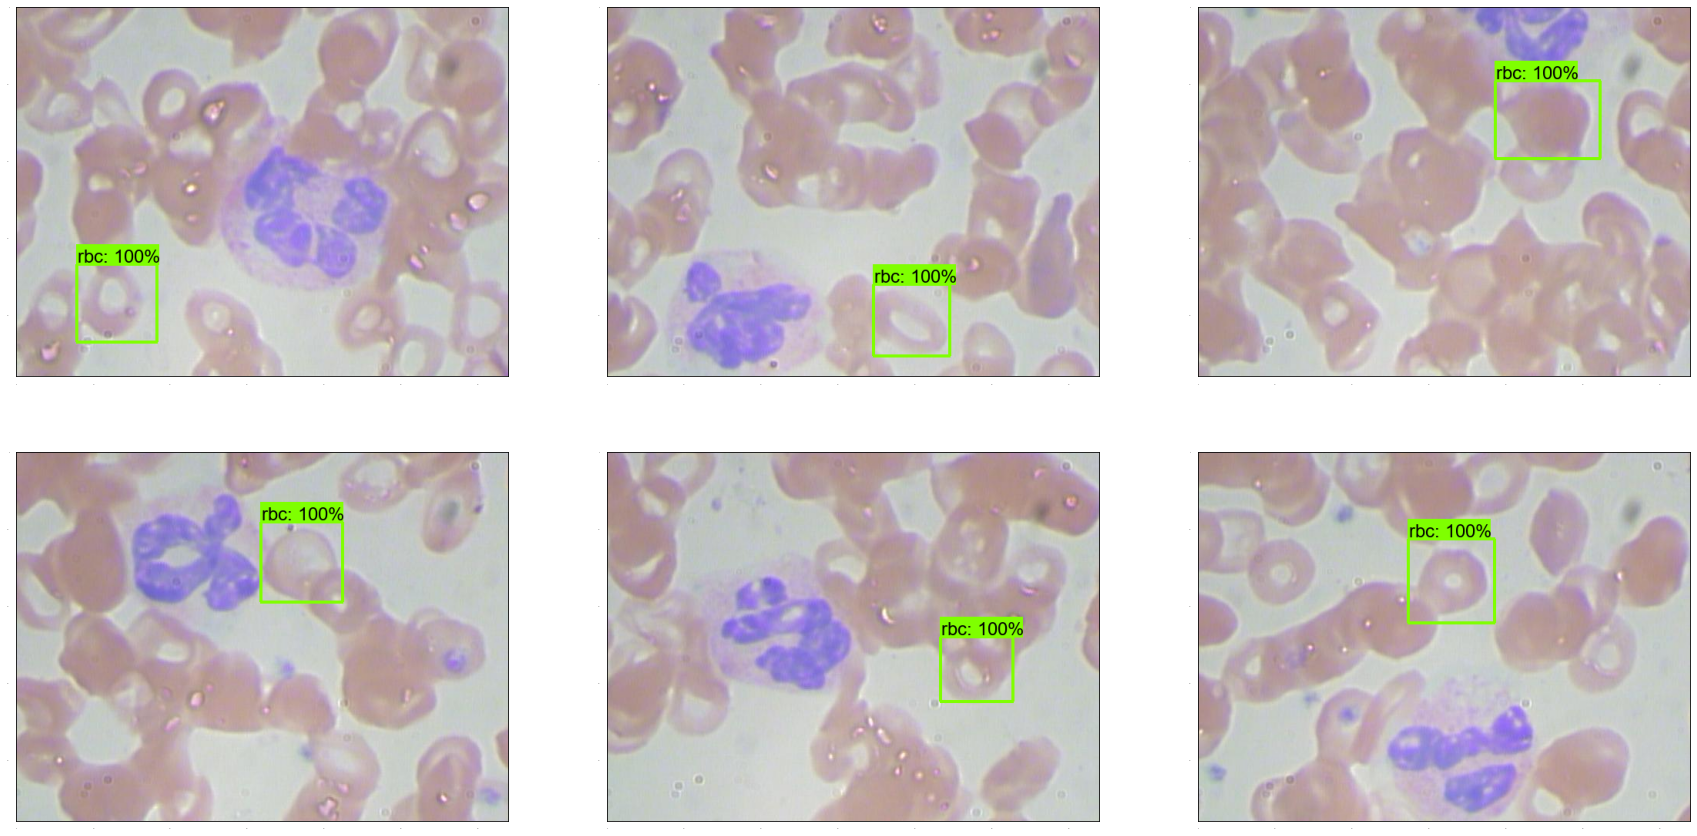

In [12]:
fake_score = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plotDetections(
        train_images[indice],
        coordenadas_info[indice],
        np.ones(shape=[coordenadas_info[indice].shape[0]], dtype=np.int32),
        fake_score, categorias)
plt.show()

# Criar modelo e trabalhar com checkpoints

In [13]:
tf.keras.backend.clear_session()
print('Construindo modelo e restaurando pesos para fine-tuning...', flush=True)

# Parâmetros do modelo
num_classes = 1
pipeline_config = '../models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'
checkpoint_path = '../models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Importação e definição
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# Construção do Modelo
model = model_builder.build(model_config=model_config, is_training=True)

fakebox_predictor = tf.compat.v2.train.Checkpoint(_base_tower_layers_for_heads=model._box_predictor._base_tower_layers_for_heads,
                                                  _box_prediction_head=model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=model._feature_extractor, _box_predictor=fakebox_predictor)

checkpoint = tf.compat.v2.train.Checkpoint(model=fake_model)
checkpoint.restore(checkpoint_path).expect_partial()

image, shapes = model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = model.predict(image, shapes)
_ = model.postprocess(prediction_dict, shapes)
print('Pesos restaurados!')

Construindo modelo e restaurando pesos para fine-tuning...
Pesos restaurados!


# Loop de treinamento personalizado

In [14]:
tf.keras.backend.set_learning_phase(True)

# Valores padrão
# batch_size = 4
# learning_rate = 0.01
# num_batches = 100

# Melhores valores até agora
# batch_size = 24
# learning_rate = 0.02
# num_batches = 200

batch_size = 24
learning_rate = 0.1
num_batches = 500

# Variáveis do Treinamento
variaveis_treino = model.trainable_variables
ajuste_fino = []
prefixo_treino = ['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for variavel in variaveis_treino:
    if any([variavel.name.startswith(prefix) for prefix in prefixo_treino]):
        ajuste_fino.append(variavel)

def passoTreino(model, otimizador, ajuste_fino):
    @tf.function
    def passo(imagem_tensors, boxes_list, classes_list):

        forma = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=boxes_list, groundtruth_classes_list=classes_list)

        with tf.GradientTape() as tape:
            prepro_images = tf.concat([model.preprocess(imagem_tensor)[
                                      0] for imagem_tensor in imagem_tensors], axis=0)
            predicao_dict = model.predict(prepro_images, forma)
            perdas_dict = model.loss(predicao_dict, forma)
            perda_total = perdas_dict['Loss/localization_loss'] + \
                perdas_dict['Loss/classification_loss']
            gradientes = tape.gradient(perda_total, ajuste_fino)
            otimizador.apply_gradients(zip(gradientes, ajuste_fino))
        return perda_total

    return passo

otimizador = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
passo = passoTreino(model, otimizador, ajuste_fino)

print('Fine-tuning inicializado!', flush=True)
for indice in range(num_batches):
    chaves = list(range(len(train_images)))
    random.shuffle(chaves)
    exemplo_chaves = chaves[:batch_size]

    boxes_list = [coordenadas_info_tensors[chave] for chave in exemplo_chaves]
    classes_list = [classes_tensors[chave] for chave in exemplo_chaves]
    image_tensors = [train_images_tensors[chave] for chave in exemplo_chaves]

    perda_total = passo(image_tensors, boxes_list, classes_list)

    if indice % 10 == 0:
        print('Batch ' + str(indice) + ' of ' + str(num_batches)
              + ', Loss = ' + str(perda_total.numpy()), flush=True)

print('Fine-tuning realizado!')

Fine-tuning inicializado!


C:\Program Files\Python38\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Batch 0 of 500, Loss = 1.2559888
Batch 10 of 500, Loss = 429.40356
Batch 20 of 500, Loss = 512.0948
Batch 30 of 500, Loss = 560.4135
Batch 40 of 500, Loss = 493.20242
Batch 50 of 500, Loss = 485.8019
Batch 60 of 500, Loss = 432.40848
Batch 70 of 500, Loss = 373.50388
Batch 80 of 500, Loss = 302.4752
Batch 90 of 500, Loss = 290.05463
Batch 100 of 500, Loss = 256.7871
Batch 110 of 500, Loss = 202.86014
Batch 120 of 500, Loss = 144.2831
Batch 130 of 500, Loss = 112.689095
Batch 140 of 500, Loss = 98.199356
Batch 150 of 500, Loss = 83.28944
Batch 160 of 500, Loss = 96.45339
Batch 170 of 500, Loss = 105.0428
Batch 180 of 500, Loss = 96.547226
Batch 190 of 500, Loss = 73.27411
Batch 200 of 500, Loss = 52.8582
Batch 210 of 500, Loss = 37.42777
Batch 220 of 500, Loss = 34.54335
Batch 230 of 500, Loss = 29.941166
Batch 240 of 500, Loss = 20.5409
Batch 250 of 500, Loss = 76.41577
Batch 260 of 500, Loss = 91.526955
Batch 270 of 500, Loss = 56.647133
Batch 280 of 500, Loss = 40.507122
Batch 290 of

# Carregar imagens para teste e aplicar no modelo

In [15]:
modelo = pipeline_config
modelo = modelo.replace("../models/", "")
modelo = modelo.replace("/pipeline.config", "")

resultados = str(batch_size) + "_" + str(learning_rate) + "_" + str(num_batches) + "_" + str(porcentagem_acerto) + "_" + str(modelo)

resultados_path = "./results-triple/" + str(resultados)
imagem_path = resultados_path + "/rbc/imagens/"
info_path = resultados_path + "/rbc/info/" 

print(resultados_path)
if not os.path.isdir(imagem_path):
    os.makedirs(imagem_path)
if not os.path.isdir(info_path):
    os.makedirs(info_path)

./results-triple/24_0.1_500_0.1_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8


In [16]:
# Diretórios para saves dentro da pasta do treinamento
save_dir = resultados_path + "/rbc/model"
save_dir_check = save_dir + "/checkpoint/"

# Salvar pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, save_dir)

# Salvar checkpoint
exported_ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, save_dir_check, max_to_keep=1)

ckpt_manager.save()
print('Checkpoint salvo com sucesso!')

INFO:tensorflow:Writing pipeline config file to ./results-triple/24_0.1_500_0.1_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/rbc/model\pipeline.config
Checkpoint salvo com sucesso!


In [17]:
test_image_dir = 'dataset-triple/test/imagens/'
test_images = []
test_images_nomes = []

for elemento in os.listdir(test_image_dir):
    imagem = os.path.join(test_image_dir, elemento)
    test_images_nomes.append(elemento)
    test_images.append(np.expand_dims(convertImageToArray(imagem), axis=0))

@tf.function
def detectar(input_tensor):
    prepross_image, formas = model.preprocess(input_tensor)
    predicao_dict = model.predict(prepross_image, formas)
    return model.postprocess(predicao_dict, formas)

offset = 1
for i in range(len(test_images)):
    test_tensor = tf.convert_to_tensor(test_images[i], dtype=tf.float32)
    deteccoes = detectar(test_tensor)

    plotDetections(
        test_images[i][0],
        deteccoes['detection_boxes'][0].numpy(),
        deteccoes['detection_classes'][0].numpy().astype(np.uint32) + offset,
        deteccoes['detection_scores'][0].numpy(),
        categorias, nome=imagem_path + test_images_nomes[i])